In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import scipy.optimize
import scipy.io
from src.utils import pathsetup, split_by_trials
import os
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression


import src.worldModels as wm
import src.utils
from src.run_simulations import run_single_agent, run_rew_error_simulations, rew_err_sweep
import src.agents as am
from tqdm.notebook import tqdm
import pandas as pd

import pickle

%matplotlib inline

%reload_ext autoreload
%autoreload 2


## Simulating a Q-learning agent for reward characterization

Q learning: rho est = 0.73, rho_interval = [0.63803113 0.81483988]
[[1.         0.49098967]
 [0.49098967 1.        ]]


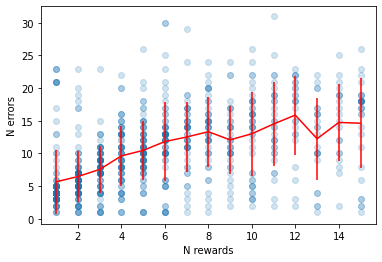

In [23]:
params = dict(nblocks=1000, seed=123, pstruct=[5, 40], agenttype='qlearning', world_pr=0.9, world_ps=0.1,
             gamma=0.05, eps=0.05)

Ne, Nr = run_rew_error_simulations(params)

seed = 124
np.random.seed(seed)
plt.figure()
plt.scatter(Nr, Ne, alpha=0.2)

# Perform the linear regression
y1 = Ne
X1 = Nr[:,np.newaxis]
X1 = sm.add_constant(X1)
model = sm.OLS(y1, X1)
res = model.fit()
rho_hat = res.params[1]
rho_interval = res.conf_int()[1,:]
print(f'Q learning: rho est = {rho_hat:.2f}, rho_interval = {rho_interval}')
print(np.corrcoef(Ne, Nr))

# Plot the binned average curve
frame = pd.DataFrame(dict(rewards=Nr, errors=Ne))
frame = frame[frame.errors > 0]
meanvals = frame.groupby('rewards')['errors'].mean().reset_index()
stdvals = frame.groupby('rewards')['errors'].std().reset_index()
plt.errorbar(meanvals.rewards, meanvals.errors, stdvals.errors, color='r')
plt.xlabel('N rewards')
plt.ylabel('N errors')

scipy.io.savemat('/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/PaperFigures/code/schematic/Qlearning_agent3_rew_err_correlations.mat', dict(params=params, Ne=Ne, Nr=Nr, 
                                  seed=seed, rho=np.corrcoef(Ne,Nr), meanvals=list(meanvals.errors), stdvals=list(stdvals.errors)))

Q learning: rho est = 0.01, rho_interval = [-0.04992723  0.06516486]
[[1.        0.0090035]
 [0.0090035 1.       ]]


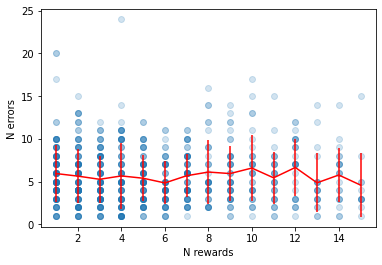

In [16]:
params = dict(nblocks=1000, seed=123, pstruct=[5, 40], agenttype='qlearning', world_pr=0.9, world_ps=0.1,
             gamma=0.6, eps=0.1)

Ne, Nr = run_rew_error_simulations(params)

seed = 126
np.random.seed(seed)
plt.figure()
plt.scatter(Nr, Ne, alpha=0.2)

# Perform the linear regression
y1 = Ne
X1 = Nr[:,np.newaxis]
X1 = sm.add_constant(X1)
model = sm.OLS(y1, X1)
res = model.fit()
rho_hat = res.params[1]
rho_interval = res.conf_int()[1,:]
print(f'Q learning: rho est = {rho_hat:.2f}, rho_interval = {rho_interval}')
print(np.corrcoef(Ne, Nr))

# Plot the binned average curve
frame = pd.DataFrame(dict(rewards=Nr, errors=Ne))
frame = frame[frame.errors > 0]
meanvals = frame.groupby('rewards')['errors'].mean().reset_index()
stdvals = frame.groupby('rewards')['errors'].std().reset_index()
plt.errorbar(meanvals.rewards, meanvals.errors, stdvals.errors, color='r')
plt.xlabel('N rewards')
plt.ylabel('N errors')

scipy.io.savemat('/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/PaperFigures/code/schematic/Qlearning_agent2_rew_err_correlations.mat', dict(params=params, Ne=Ne, Nr=Nr, 
                              seed=seed, rho=np.corrcoef(Ne,Nr), meanvals=list(meanvals.errors), stdvals=list(stdvals.errors)))

Q learning: rho est = 0.42, rho_interval = [0.40490444 0.43729424]


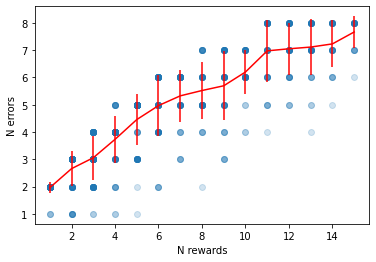

In [6]:
params = dict(nblocks=1000, seed=123, pstruct=[5, 40], agenttype='inf-based', world_pr=0.9, world_ps=0.1,
             psw=0.02, prew=0.55)

Ne, Nr = run_rew_error_simulations(params)

seed = 123
np.random.seed(seed)

plt.figure()
plt.scatter(Nr, Ne, alpha=0.2)

# Perform the linear regression
y1 = Ne
X1 = Nr[:,np.newaxis]
X1 = sm.add_constant(X1)
model = sm.OLS(y1, X1)
res = model.fit()
rho_hat = res.params[1]
rho_interval = res.conf_int()[1,:]
print(f'Q learning: rho est = {rho_hat:.2f}, rho_interval = {rho_interval}')

# Plot the binned average curve
frame = pd.DataFrame(dict(rewards=Nr, errors=Ne))
frame = frame[frame.errors > 0]
meanvals = frame.groupby('rewards')['errors'].mean().reset_index()
stdvals = frame.groupby('rewards')['errors'].std().reset_index()
plt.errorbar(meanvals.rewards, meanvals.errors, stdvals.errors, color='r')
plt.xlabel('N rewards')
plt.ylabel('N errors')

scipy.io.savemat('/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/PaperFigures/code/schematic/infbased_agent1_rew_err_correlations.mat', dict(params=params, Ne=Ne, Nr=Nr, 
                              seed=seed, rho=np.corrcoef(Ne,Nr), meanvals=list(meanvals.errors), stdvals=list(stdvals.errors)))

Q learning: rho est = 0.00, rho_interval = [-0.00463824  0.00642094]


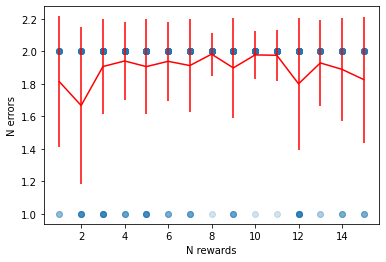

In [7]:
params = dict(nblocks=1000, seed=123, pstruct=[5, 40], agenttype='inf-based', world_pr=0.9, world_ps=0.1,
             psw=0.1, prew=0.7)

Ne, Nr = run_rew_error_simulations(params)

seed = 123
np.random.seed(seed)

plt.figure()
plt.scatter(Nr, Ne, alpha=0.2)

# Perform the linear regression
y1 = Ne
X1 = Nr[:,np.newaxis]
X1 = sm.add_constant(X1)
model = sm.OLS(y1, X1)
res = model.fit()
rho_hat = res.params[1]
rho_interval = res.conf_int()[1,:]
print(f'Q learning: rho est = {rho_hat:.2f}, rho_interval = {rho_interval}')

# Plot the binned average curve
frame = pd.DataFrame(dict(rewards=Nr, errors=Ne))
frame = frame[frame.errors > 0]
meanvals = frame.groupby('rewards')['errors'].mean().reset_index()
stdvals = frame.groupby('rewards')['errors'].std().reset_index()
plt.errorbar(meanvals.rewards, meanvals.errors, stdvals.errors, color='r')
plt.xlabel('N rewards')
plt.ylabel('N errors')

scipy.io.savemat('/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/PaperFigures/code/schematic/infbased_agent2_rew_err_correlations.mat', dict(params=params, Ne=Ne, Nr=Nr, 
                              seed=seed, rho=np.corrcoef(Ne,Nr), meanvals=list(meanvals.errors), stdvals=list(stdvals.errors)))

In [10]:
# A systematic simulation of the whole space
params = dict(nblocks=1000, seed=123, pstruct=[5, 40], agenttype='qlearning', world_pr=0.9, world_ps=0.1,
             gamma=np.linspace(0.01, 0.9, 30), eps=np.linspace(0.01, 0.5, 30))
corr_arr_Q = rew_err_sweep(params)

  0%|          | 0/30 [00:00<?, ?it/s]

i = 0, gamma = 0.01, j = 0, eps = 0.01
i = 0, gamma = 0.01, j = 1, eps = 0.026896551724137928
i = 0, gamma = 0.01, j = 2, eps = 0.04379310344827586
i = 0, gamma = 0.01, j = 3, eps = 0.060689655172413794
i = 0, gamma = 0.01, j = 4, eps = 0.07758620689655171
i = 0, gamma = 0.01, j = 5, eps = 0.09448275862068964
i = 0, gamma = 0.01, j = 6, eps = 0.11137931034482758
i = 0, gamma = 0.01, j = 7, eps = 0.12827586206896552
i = 0, gamma = 0.01, j = 8, eps = 0.14517241379310344
i = 0, gamma = 0.01, j = 9, eps = 0.16206896551724137
i = 0, gamma = 0.01, j = 10, eps = 0.1789655172413793
i = 0, gamma = 0.01, j = 11, eps = 0.19586206896551722
i = 0, gamma = 0.01, j = 12, eps = 0.21275862068965518
i = 0, gamma = 0.01, j = 13, eps = 0.2296551724137931
i = 0, gamma = 0.01, j = 14, eps = 0.24655172413793103
i = 0, gamma = 0.01, j = 15, eps = 0.2634482758620689
i = 0, gamma = 0.01, j = 16, eps = 0.2803448275862069
i = 0, gamma = 0.01, j = 17, eps = 0.29724137931034483
i = 0, gamma = 0.01, j = 18, eps = 0.

i = 4, gamma = 0.1327586206896552, j = 8, eps = 0.14517241379310344
i = 4, gamma = 0.1327586206896552, j = 9, eps = 0.16206896551724137
i = 4, gamma = 0.1327586206896552, j = 10, eps = 0.1789655172413793
i = 4, gamma = 0.1327586206896552, j = 11, eps = 0.19586206896551722
i = 4, gamma = 0.1327586206896552, j = 12, eps = 0.21275862068965518
i = 4, gamma = 0.1327586206896552, j = 13, eps = 0.2296551724137931
i = 4, gamma = 0.1327586206896552, j = 14, eps = 0.24655172413793103
i = 4, gamma = 0.1327586206896552, j = 15, eps = 0.2634482758620689
i = 4, gamma = 0.1327586206896552, j = 16, eps = 0.2803448275862069
i = 4, gamma = 0.1327586206896552, j = 17, eps = 0.29724137931034483
i = 4, gamma = 0.1327586206896552, j = 18, eps = 0.31413793103448273
i = 4, gamma = 0.1327586206896552, j = 19, eps = 0.3310344827586207
i = 4, gamma = 0.1327586206896552, j = 20, eps = 0.3479310344827586
i = 4, gamma = 0.1327586206896552, j = 21, eps = 0.36482758620689654
i = 4, gamma = 0.1327586206896552, j = 22,

i = 8, gamma = 0.25551724137931037, j = 9, eps = 0.16206896551724137
i = 8, gamma = 0.25551724137931037, j = 10, eps = 0.1789655172413793
i = 8, gamma = 0.25551724137931037, j = 11, eps = 0.19586206896551722
i = 8, gamma = 0.25551724137931037, j = 12, eps = 0.21275862068965518
i = 8, gamma = 0.25551724137931037, j = 13, eps = 0.2296551724137931
i = 8, gamma = 0.25551724137931037, j = 14, eps = 0.24655172413793103
i = 8, gamma = 0.25551724137931037, j = 15, eps = 0.2634482758620689
i = 8, gamma = 0.25551724137931037, j = 16, eps = 0.2803448275862069
i = 8, gamma = 0.25551724137931037, j = 17, eps = 0.29724137931034483
i = 8, gamma = 0.25551724137931037, j = 18, eps = 0.31413793103448273
i = 8, gamma = 0.25551724137931037, j = 19, eps = 0.3310344827586207
i = 8, gamma = 0.25551724137931037, j = 20, eps = 0.3479310344827586
i = 8, gamma = 0.25551724137931037, j = 21, eps = 0.36482758620689654
i = 8, gamma = 0.25551724137931037, j = 22, eps = 0.38172413793103444
i = 8, gamma = 0.2555172413

i = 12, gamma = 0.3782758620689656, j = 8, eps = 0.14517241379310344
i = 12, gamma = 0.3782758620689656, j = 9, eps = 0.16206896551724137
i = 12, gamma = 0.3782758620689656, j = 10, eps = 0.1789655172413793
i = 12, gamma = 0.3782758620689656, j = 11, eps = 0.19586206896551722
i = 12, gamma = 0.3782758620689656, j = 12, eps = 0.21275862068965518
i = 12, gamma = 0.3782758620689656, j = 13, eps = 0.2296551724137931
i = 12, gamma = 0.3782758620689656, j = 14, eps = 0.24655172413793103
i = 12, gamma = 0.3782758620689656, j = 15, eps = 0.2634482758620689
i = 12, gamma = 0.3782758620689656, j = 16, eps = 0.2803448275862069
i = 12, gamma = 0.3782758620689656, j = 17, eps = 0.29724137931034483
i = 12, gamma = 0.3782758620689656, j = 18, eps = 0.31413793103448273
i = 12, gamma = 0.3782758620689656, j = 19, eps = 0.3310344827586207
i = 12, gamma = 0.3782758620689656, j = 20, eps = 0.3479310344827586
i = 12, gamma = 0.3782758620689656, j = 21, eps = 0.36482758620689654
i = 12, gamma = 0.3782758620

i = 16, gamma = 0.5010344827586207, j = 7, eps = 0.12827586206896552
i = 16, gamma = 0.5010344827586207, j = 8, eps = 0.14517241379310344
i = 16, gamma = 0.5010344827586207, j = 9, eps = 0.16206896551724137
i = 16, gamma = 0.5010344827586207, j = 10, eps = 0.1789655172413793
i = 16, gamma = 0.5010344827586207, j = 11, eps = 0.19586206896551722
i = 16, gamma = 0.5010344827586207, j = 12, eps = 0.21275862068965518
i = 16, gamma = 0.5010344827586207, j = 13, eps = 0.2296551724137931
i = 16, gamma = 0.5010344827586207, j = 14, eps = 0.24655172413793103
i = 16, gamma = 0.5010344827586207, j = 15, eps = 0.2634482758620689
i = 16, gamma = 0.5010344827586207, j = 16, eps = 0.2803448275862069
i = 16, gamma = 0.5010344827586207, j = 17, eps = 0.29724137931034483
i = 16, gamma = 0.5010344827586207, j = 18, eps = 0.31413793103448273
i = 16, gamma = 0.5010344827586207, j = 19, eps = 0.3310344827586207
i = 16, gamma = 0.5010344827586207, j = 20, eps = 0.3479310344827586
i = 16, gamma = 0.50103448275

i = 20, gamma = 0.6237931034482759, j = 9, eps = 0.16206896551724137
i = 20, gamma = 0.6237931034482759, j = 10, eps = 0.1789655172413793
i = 20, gamma = 0.6237931034482759, j = 11, eps = 0.19586206896551722
i = 20, gamma = 0.6237931034482759, j = 12, eps = 0.21275862068965518
i = 20, gamma = 0.6237931034482759, j = 13, eps = 0.2296551724137931
i = 20, gamma = 0.6237931034482759, j = 14, eps = 0.24655172413793103
i = 20, gamma = 0.6237931034482759, j = 15, eps = 0.2634482758620689
i = 20, gamma = 0.6237931034482759, j = 16, eps = 0.2803448275862069
i = 20, gamma = 0.6237931034482759, j = 17, eps = 0.29724137931034483
i = 20, gamma = 0.6237931034482759, j = 18, eps = 0.31413793103448273
i = 20, gamma = 0.6237931034482759, j = 19, eps = 0.3310344827586207
i = 20, gamma = 0.6237931034482759, j = 20, eps = 0.3479310344827586
i = 20, gamma = 0.6237931034482759, j = 21, eps = 0.36482758620689654
i = 20, gamma = 0.6237931034482759, j = 22, eps = 0.38172413793103444
i = 20, gamma = 0.623793103

i = 24, gamma = 0.7465517241379311, j = 9, eps = 0.16206896551724137
i = 24, gamma = 0.7465517241379311, j = 10, eps = 0.1789655172413793
i = 24, gamma = 0.7465517241379311, j = 11, eps = 0.19586206896551722
i = 24, gamma = 0.7465517241379311, j = 12, eps = 0.21275862068965518
i = 24, gamma = 0.7465517241379311, j = 13, eps = 0.2296551724137931
i = 24, gamma = 0.7465517241379311, j = 14, eps = 0.24655172413793103
i = 24, gamma = 0.7465517241379311, j = 15, eps = 0.2634482758620689
i = 24, gamma = 0.7465517241379311, j = 16, eps = 0.2803448275862069
i = 24, gamma = 0.7465517241379311, j = 17, eps = 0.29724137931034483
i = 24, gamma = 0.7465517241379311, j = 18, eps = 0.31413793103448273
i = 24, gamma = 0.7465517241379311, j = 19, eps = 0.3310344827586207
i = 24, gamma = 0.7465517241379311, j = 20, eps = 0.3479310344827586
i = 24, gamma = 0.7465517241379311, j = 21, eps = 0.36482758620689654
i = 24, gamma = 0.7465517241379311, j = 22, eps = 0.38172413793103444
i = 24, gamma = 0.746551724

i = 28, gamma = 0.8693103448275863, j = 9, eps = 0.16206896551724137
i = 28, gamma = 0.8693103448275863, j = 10, eps = 0.1789655172413793
i = 28, gamma = 0.8693103448275863, j = 11, eps = 0.19586206896551722
i = 28, gamma = 0.8693103448275863, j = 12, eps = 0.21275862068965518
i = 28, gamma = 0.8693103448275863, j = 13, eps = 0.2296551724137931
i = 28, gamma = 0.8693103448275863, j = 14, eps = 0.24655172413793103
i = 28, gamma = 0.8693103448275863, j = 15, eps = 0.2634482758620689
i = 28, gamma = 0.8693103448275863, j = 16, eps = 0.2803448275862069
i = 28, gamma = 0.8693103448275863, j = 17, eps = 0.29724137931034483
i = 28, gamma = 0.8693103448275863, j = 18, eps = 0.31413793103448273
i = 28, gamma = 0.8693103448275863, j = 19, eps = 0.3310344827586207
i = 28, gamma = 0.8693103448275863, j = 20, eps = 0.3479310344827586
i = 28, gamma = 0.8693103448275863, j = 21, eps = 0.36482758620689654
i = 28, gamma = 0.8693103448275863, j = 22, eps = 0.38172413793103444
i = 28, gamma = 0.869310344

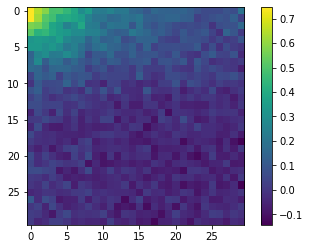

In [11]:
plt.imshow(corr_arr_Q)
plt.colorbar()

In [7]:
# A systematic simulation of the whole space
params = dict(nblocks=1000, seed=123, pstruct=[5, 40], agenttype='inf-based', world_pr=0.9, world_ps=0.1,
             psw=np.linspace(0.01, 0.5, 30), prew=np.linspace(0.55, 0.99, 30))
corr_arr = rew_err_sweep(params)


  0%|          | 0/30 [00:00<?, ?it/s]

i = 0, gamma = 0.01, j = 0, eps = 0.55
i = 0, gamma = 0.01, j = 1, eps = 0.5651724137931035
i = 0, gamma = 0.01, j = 2, eps = 0.580344827586207
i = 0, gamma = 0.01, j = 3, eps = 0.5955172413793104
i = 0, gamma = 0.01, j = 4, eps = 0.6106896551724138
i = 0, gamma = 0.01, j = 5, eps = 0.6258620689655172
i = 0, gamma = 0.01, j = 6, eps = 0.6410344827586207
i = 0, gamma = 0.01, j = 7, eps = 0.6562068965517242
i = 0, gamma = 0.01, j = 8, eps = 0.6713793103448276
i = 0, gamma = 0.01, j = 9, eps = 0.6865517241379311
i = 0, gamma = 0.01, j = 10, eps = 0.7017241379310345
i = 0, gamma = 0.01, j = 11, eps = 0.7168965517241379
i = 0, gamma = 0.01, j = 12, eps = 0.7320689655172414
i = 0, gamma = 0.01, j = 13, eps = 0.7472413793103448
i = 0, gamma = 0.01, j = 14, eps = 0.7624137931034483
i = 0, gamma = 0.01, j = 15, eps = 0.7775862068965518
i = 0, gamma = 0.01, j = 16, eps = 0.7927586206896552
i = 0, gamma = 0.01, j = 17, eps = 0.8079310344827586
i = 0, gamma = 0.01, j = 18, eps = 0.8231034482758621

/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


i = 1, gamma = 0.026896551724137928, j = 0, eps = 0.55
i = 1, gamma = 0.026896551724137928, j = 1, eps = 0.5651724137931035
i = 1, gamma = 0.026896551724137928, j = 2, eps = 0.580344827586207
i = 1, gamma = 0.026896551724137928, j = 3, eps = 0.5955172413793104
i = 1, gamma = 0.026896551724137928, j = 4, eps = 0.6106896551724138
i = 1, gamma = 0.026896551724137928, j = 5, eps = 0.6258620689655172
i = 1, gamma = 0.026896551724137928, j = 6, eps = 0.6410344827586207
i = 1, gamma = 0.026896551724137928, j = 7, eps = 0.6562068965517242
i = 1, gamma = 0.026896551724137928, j = 8, eps = 0.6713793103448276
i = 1, gamma = 0.026896551724137928, j = 9, eps = 0.6865517241379311
i = 1, gamma = 0.026896551724137928, j = 10, eps = 0.7017241379310345
i = 1, gamma = 0.026896551724137928, j = 11, eps = 0.7168965517241379
i = 1, gamma = 0.026896551724137928, j = 12, eps = 0.7320689655172414
i = 1, gamma = 0.026896551724137928, j = 13, eps = 0.7472413793103448
i = 1, gamma = 0.026896551724137928, j = 14, 

i = 5, gamma = 0.09448275862068964, j = 3, eps = 0.5955172413793104
i = 5, gamma = 0.09448275862068964, j = 4, eps = 0.6106896551724138
i = 5, gamma = 0.09448275862068964, j = 5, eps = 0.6258620689655172
i = 5, gamma = 0.09448275862068964, j = 6, eps = 0.6410344827586207
i = 5, gamma = 0.09448275862068964, j = 7, eps = 0.6562068965517242
i = 5, gamma = 0.09448275862068964, j = 8, eps = 0.6713793103448276
i = 5, gamma = 0.09448275862068964, j = 9, eps = 0.6865517241379311
i = 5, gamma = 0.09448275862068964, j = 10, eps = 0.7017241379310345
i = 5, gamma = 0.09448275862068964, j = 11, eps = 0.7168965517241379
i = 5, gamma = 0.09448275862068964, j = 12, eps = 0.7320689655172414
i = 5, gamma = 0.09448275862068964, j = 13, eps = 0.7472413793103448
i = 5, gamma = 0.09448275862068964, j = 14, eps = 0.7624137931034483
i = 5, gamma = 0.09448275862068964, j = 15, eps = 0.7775862068965518
i = 5, gamma = 0.09448275862068964, j = 16, eps = 0.7927586206896552
i = 5, gamma = 0.09448275862068964, j = 1

i = 9, gamma = 0.16206896551724137, j = 5, eps = 0.6258620689655172
i = 9, gamma = 0.16206896551724137, j = 6, eps = 0.6410344827586207
i = 9, gamma = 0.16206896551724137, j = 7, eps = 0.6562068965517242
i = 9, gamma = 0.16206896551724137, j = 8, eps = 0.6713793103448276
i = 9, gamma = 0.16206896551724137, j = 9, eps = 0.6865517241379311
i = 9, gamma = 0.16206896551724137, j = 10, eps = 0.7017241379310345
i = 9, gamma = 0.16206896551724137, j = 11, eps = 0.7168965517241379
i = 9, gamma = 0.16206896551724137, j = 12, eps = 0.7320689655172414
i = 9, gamma = 0.16206896551724137, j = 13, eps = 0.7472413793103448
i = 9, gamma = 0.16206896551724137, j = 14, eps = 0.7624137931034483
i = 9, gamma = 0.16206896551724137, j = 15, eps = 0.7775862068965518
i = 9, gamma = 0.16206896551724137, j = 16, eps = 0.7927586206896552
i = 9, gamma = 0.16206896551724137, j = 17, eps = 0.8079310344827586
i = 9, gamma = 0.16206896551724137, j = 18, eps = 0.8231034482758621
i = 9, gamma = 0.16206896551724137, j =

i = 13, gamma = 0.2296551724137931, j = 8, eps = 0.6713793103448276
i = 13, gamma = 0.2296551724137931, j = 9, eps = 0.6865517241379311
i = 13, gamma = 0.2296551724137931, j = 10, eps = 0.7017241379310345
i = 13, gamma = 0.2296551724137931, j = 11, eps = 0.7168965517241379
i = 13, gamma = 0.2296551724137931, j = 12, eps = 0.7320689655172414
i = 13, gamma = 0.2296551724137931, j = 13, eps = 0.7472413793103448
i = 13, gamma = 0.2296551724137931, j = 14, eps = 0.7624137931034483
i = 13, gamma = 0.2296551724137931, j = 15, eps = 0.7775862068965518
i = 13, gamma = 0.2296551724137931, j = 16, eps = 0.7927586206896552
i = 13, gamma = 0.2296551724137931, j = 17, eps = 0.8079310344827586
i = 13, gamma = 0.2296551724137931, j = 18, eps = 0.8231034482758621
i = 13, gamma = 0.2296551724137931, j = 19, eps = 0.8382758620689655
i = 13, gamma = 0.2296551724137931, j = 20, eps = 0.853448275862069
i = 13, gamma = 0.2296551724137931, j = 21, eps = 0.8686206896551725
i = 13, gamma = 0.2296551724137931, j

i = 17, gamma = 0.29724137931034483, j = 11, eps = 0.7168965517241379
i = 17, gamma = 0.29724137931034483, j = 12, eps = 0.7320689655172414
i = 17, gamma = 0.29724137931034483, j = 13, eps = 0.7472413793103448
i = 17, gamma = 0.29724137931034483, j = 14, eps = 0.7624137931034483
i = 17, gamma = 0.29724137931034483, j = 15, eps = 0.7775862068965518
i = 17, gamma = 0.29724137931034483, j = 16, eps = 0.7927586206896552
i = 17, gamma = 0.29724137931034483, j = 17, eps = 0.8079310344827586
i = 17, gamma = 0.29724137931034483, j = 18, eps = 0.8231034482758621
i = 17, gamma = 0.29724137931034483, j = 19, eps = 0.8382758620689655
i = 17, gamma = 0.29724137931034483, j = 20, eps = 0.853448275862069
i = 17, gamma = 0.29724137931034483, j = 21, eps = 0.8686206896551725
i = 17, gamma = 0.29724137931034483, j = 22, eps = 0.8837931034482759
i = 17, gamma = 0.29724137931034483, j = 23, eps = 0.8989655172413793
i = 17, gamma = 0.29724137931034483, j = 24, eps = 0.9141379310344828
i = 17, gamma = 0.297

i = 21, gamma = 0.36482758620689654, j = 13, eps = 0.7472413793103448
i = 21, gamma = 0.36482758620689654, j = 14, eps = 0.7624137931034483
i = 21, gamma = 0.36482758620689654, j = 15, eps = 0.7775862068965518
i = 21, gamma = 0.36482758620689654, j = 16, eps = 0.7927586206896552
i = 21, gamma = 0.36482758620689654, j = 17, eps = 0.8079310344827586
i = 21, gamma = 0.36482758620689654, j = 18, eps = 0.8231034482758621
i = 21, gamma = 0.36482758620689654, j = 19, eps = 0.8382758620689655
i = 21, gamma = 0.36482758620689654, j = 20, eps = 0.853448275862069
i = 21, gamma = 0.36482758620689654, j = 21, eps = 0.8686206896551725
i = 21, gamma = 0.36482758620689654, j = 22, eps = 0.8837931034482759
i = 21, gamma = 0.36482758620689654, j = 23, eps = 0.8989655172413793
i = 21, gamma = 0.36482758620689654, j = 24, eps = 0.9141379310344828
i = 21, gamma = 0.36482758620689654, j = 25, eps = 0.9293103448275862
i = 21, gamma = 0.36482758620689654, j = 26, eps = 0.9444827586206896
i = 21, gamma = 0.364

i = 25, gamma = 0.43241379310344824, j = 14, eps = 0.7624137931034483
i = 25, gamma = 0.43241379310344824, j = 15, eps = 0.7775862068965518
i = 25, gamma = 0.43241379310344824, j = 16, eps = 0.7927586206896552
i = 25, gamma = 0.43241379310344824, j = 17, eps = 0.8079310344827586
i = 25, gamma = 0.43241379310344824, j = 18, eps = 0.8231034482758621
i = 25, gamma = 0.43241379310344824, j = 19, eps = 0.8382758620689655
i = 25, gamma = 0.43241379310344824, j = 20, eps = 0.853448275862069
i = 25, gamma = 0.43241379310344824, j = 21, eps = 0.8686206896551725
i = 25, gamma = 0.43241379310344824, j = 22, eps = 0.8837931034482759
i = 25, gamma = 0.43241379310344824, j = 23, eps = 0.8989655172413793
i = 25, gamma = 0.43241379310344824, j = 24, eps = 0.9141379310344828
i = 25, gamma = 0.43241379310344824, j = 25, eps = 0.9293103448275862
i = 25, gamma = 0.43241379310344824, j = 26, eps = 0.9444827586206896
i = 25, gamma = 0.43241379310344824, j = 27, eps = 0.9596551724137932
i = 25, gamma = 0.432

i = 29, gamma = 0.5, j = 19, eps = 0.8382758620689655
i = 29, gamma = 0.5, j = 20, eps = 0.853448275862069
i = 29, gamma = 0.5, j = 21, eps = 0.8686206896551725
i = 29, gamma = 0.5, j = 22, eps = 0.8837931034482759
i = 29, gamma = 0.5, j = 23, eps = 0.8989655172413793
i = 29, gamma = 0.5, j = 24, eps = 0.9141379310344828
i = 29, gamma = 0.5, j = 25, eps = 0.9293103448275862
i = 29, gamma = 0.5, j = 26, eps = 0.9444827586206896
i = 29, gamma = 0.5, j = 27, eps = 0.9596551724137932
i = 29, gamma = 0.5, j = 28, eps = 0.9748275862068966
i = 29, gamma = 0.5, j = 29, eps = 0.99


In [9]:
corr_arr_ib = corr_arr

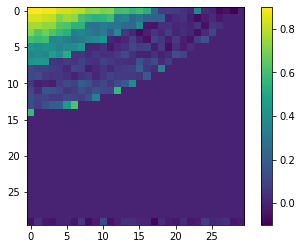

In [8]:
corr_arr[np.isnan(corr_arr)] = 0
plt.imshow(corr_arr)
plt.colorbar()

In [12]:
params = dict(gamma=np.linspace(0.01, 0.9, 30),
              eps=np.linspace(0.01, 0.5, 30),
              nblocks=1000, seed=123, pstruct=[5, 40], 
              world_pr=0.9, world_ps=0.1,
              psw=np.linspace(0.01, 0.5, 30), prew=np.linspace(0.55, 0.99, 30),
             corr_arr_ib=corr_arr_ib, corr_arr_Q = corr_arr_Q)

scipy.io.savemat('corr_arr_simulations.mat', params)

## For showing the schematic of $\rho$ calculation

In [56]:
np.random.seed(123)
world = wm.ForagingWorld(prew=0.9, psw=0.1, pstruct=[5, 40], nblockmax=1000)
agent = am.EGreedyQLearningAgent(gamma=0.1, eps=0.01)

exp = wm.Experiment(agent, world)
exp.run()

Nerrors = src.utils.get_num_errors_leading_block(world, agent)[1:]
Nrews = src.utils.get_num_rewards_trailing_block(world, agent)[:-1]

Nerrors_trim = Nerrors[(Nerrors > 0) & (Nrews > 0) & (Nrews <= 15)]
Nrews_trim = Nrews[(Nerrors > 0) & (Nrews > 0) & (Nrews <= 15)]

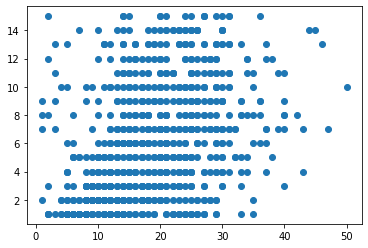

In [57]:
plt.scatter(Nerrors_trim, Nrews_trim)

In [63]:
np.where((Nerrors == 10) & (Nrews == 14))

(array([4]),)

In [79]:
choicelst = split_by_trials(agent.choice_history, world.ntrialblocks, chop='max')
q1lst = split_by_trials(agent.q1_history, world.ntrialblocks, chop='max')
q0lst = split_by_trials(agent.q0_history, world.ntrialblocks, chop='max')

In [38]:
len(choicelst)

1000

In [80]:
choicelst[8]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [61]:
choicelst[9]

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])

In [64]:
choicelst[4]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [65]:
choicelst[5]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

(0.0, 1.0)

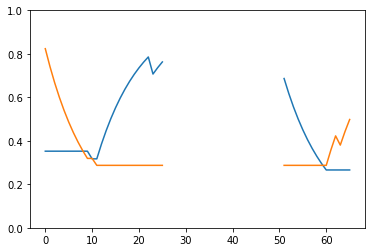

In [81]:
plt.plot(np.hstack(q0lst[4:6]))
plt.plot(np.hstack(q1lst[4:6]))
plt.ylim([0, 1])

(0.0, 1.0)

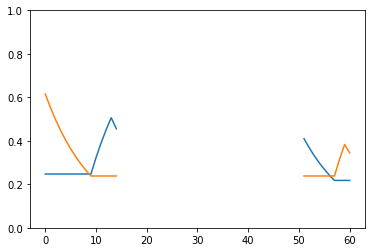

In [82]:
plt.plot(np.hstack(q0lst[8:10]))
plt.plot(np.hstack(q1lst[8:10]))
plt.ylim([0, 1])

In [83]:
scipy.io.savemat('rew_err_correlations_schematic.mat', dict(prew=0.9, psw=0.1, pstruct=[5, 40], nblockmax=1000,
                                                           gamma=0.1, eps=0.01, pos1=4, pos2=8, choicelst=choicelst,
                                                           q0lst=q0lst, q1lst=q1lst))

## Further exploration of lapse rate

In [4]:
np.random.seed(123)
rlow = 0.2
rhigh = 0.8
nblocks = 1000
ntrials_per_block = [15, 25]
# world = wm.ForagingWorld(prew=0.9, psw=0.1, pstruct=[5, 40], nblockmax=1000)
world, _ = src.utils.make_switching_world(rlow, rhigh, nblocks, ntrials_per_block[0], ntrials_per_block[1])
# agent = am.EGreedyQLearningAgent(gamma=0.1, eps=0.01)
agent = am.EGreedyInferenceBasedAgent(prew=0.75, pswitch=0.1)

exp = wm.Experiment(agent, world)
exp.run()

Nerrors = src.utils.get_num_errors_leading_block(world, agent)[1:]
Nrews = src.utils.get_num_rewards_trailing_block(world, agent)[:-1]

Nerrors_trim = Nerrors[(Nerrors > 0) & (Nrews > 0) & (Nrews <= 15)]
Nrews_trim = Nrews[(Nerrors > 0) & (Nrews > 0) & (Nrews <= 15)]

In [5]:
choicearr = split_by_trials(agent.outcome_history, world.ntrialblocks, chop='max')